In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image
from io import BytesIO

from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.utils.colpali_processing_utils import (
    process_images,
    process_queries,
)
from colpali_engine.utils.image_utils import scale_image, get_base64_image

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    type = torch.bfloat16
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    type = torch.float32
else:
    device = torch.device("cpu")
    type = torch.float32

In [ ]:
!pip install seaborn

In [ ]:
!pip install -q -U "colpali-engine[interpretability]>=0.3.2,<0.4.0"

In [89]:
model_name = "vidore/colpali-v1.2"
model = cast(ColPali,ColPali.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base", torch_dtype=type)
).eval()
model.load_adapter(model_name)
model = model.eval()
model.to(device)
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

In [21]:
import requests
from pdf2image import convert_from_path
from pypdf import PdfReader


def download_pdf(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        raise Exception(f"Failed to download PDF: Status code {response.status_code}")


def get_pdf_images(pdf_url):#
    # Download the PDF
    #pdf_file = download_pdf(pdf_url)
    # Save the PDF temporarily to disk (pdf2image requires a file path)
    # with open("temp.pdf", "wb") as f:
    #     f.write(pdf_file.read())
    reader = PdfReader("/home/ubuntu/pdfs/uk_house.pdf")
    page_texts = []
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        text = page.extract_text()
        page_texts.append(text)
    images = convert_from_path("/home/ubuntu/pdfs/uk_house.pdf")
    assert len(images) == len(page_texts)
    return (images, page_texts)

In [23]:
sample_pdfs = [
    # {
    #     "title": "ColBERTv2: Effective and Efficient Retrieval via Lightweight Late Interaction",
    #     "url": "https://arxiv.org/pdf/2112.01488.pdf",
    #     "authors": "Keshav Santhanam, Omar Khattab, Jon Saad-Falcon, Christopher Potts, Matei Zaharia",
    # },
    {
        "title": "UK House Price",
        "url": "https://github.com/aws-samples/AI-search-with-amazon-opensearch-service/blob/b559f82c07dfcca973f457c0a15d6444752553ab/rag/sample_pdfs/HPI-Jan-2024-Hometrack.pdf",
        "authors": "Omar Khattab, Matei Zaharia",
    }]

In [24]:
for pdf in sample_pdfs:
    page_images, page_texts = get_pdf_images(pdf["url"])
    pdf["images"] = page_images
    pdf["texts"] = page_texts

In [ ]:
len(page_texts)

In [27]:


page_images = [page_images[2]]

In [30]:
sample_pdfs[0]['images'] = page_images

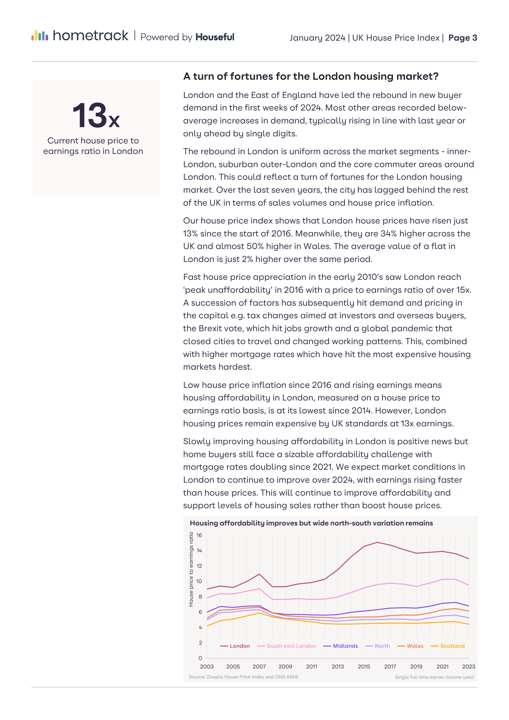

In [31]:
from IPython.display import display

display(scale_image(sample_pdfs[0]["images"][0], 720))

In [32]:
for pdf in sample_pdfs:
    page_embeddings = []
    dataloader = DataLoader(
        pdf["images"],
        batch_size=2,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x),
    )
    for batch_doc in tqdm(dataloader):
        with torch.no_grad():
            batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
            embeddings_doc = model(**batch_doc)
            page_embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))
    pdf["embeddings"] = page_embeddings

100%|██████████| 1/1 [00:38<00:00, 38.51s/it]


In [77]:
page_embeddings = embeddings_doc

In [78]:
embeddings_doc.size()

torch.Size([1, 1030, 128])

In [ ]:
len(sample_pdfs[1]["embeddings"][9])

In [ ]:
import numpy as np
from typing import Dict, List
from binascii import hexlify


def binarize_token_vectors_hex(vectors: List[torch.Tensor]) -> Dict[str, str]:
    vespa_tensor = list()
    for page_id in range(0, len(vectors)):
        page_vector = vectors[page_id]
        # print(page_id)
        # print(page_vector[0])
        # print(len(page_vector[0]))
        # print("---------------")
        binarized_token_vectors = np.packbits(
            np.where(page_vector > 0, 1, 0), axis=1
        ).astype(np.int8)
        for patch_index in range(0, len(page_vector)):
            values = str(
                hexlify(binarized_token_vectors[patch_index].tobytes()), "utf-8"
            )
            if (
                values == "00000000000000000000000000000000"
            ):  # skip empty vectors due to padding of batch
                continue
            vespa_tensor_cell = {
                "address": {"page": page_id, "patch": patch_index},
                "values": values,
            }
            vespa_tensor.append(vespa_tensor_cell)

    return vespa_tensor

In [ ]:
pdf_1 = sample_pdfs[0]


In [ ]:
pdf_1

In [ ]:
page_wise_documents = []
images_base_64=[]
for page_num, image in enumerate(pdf_1["images"]):#iterate through pages
    #images_base_64.append(get_base64_image(image, add_url_prefix=False))
    patch_vectors = pdf_1['embeddings'][page_num]
    doc = {
    
        "pdf_url": pdf_1["url"],
        "pdf_title": pdf_1["title"],
        "page_image": get_base64_image(image, add_url_prefix=False),
        "page_num": page_num,
        "page_texts": pdf_1["texts"][page_num],  # Array of text per page
        "page_embedding": (np.average(patch_vectors, axis=0)).tolist()
        }
    for patch_num,patch in enumerate(patch_vectors):
        doc['patch-'+str(patch_num)] = patch.tolist()
    page_wise_documents.append(doc)
page_wise_documents  

In [ ]:
OpenSearchDomainEndpoint = 'search-opensearchservi-75ucark0bqob-bzk6r6h2t33dlnpgx2pdeg22gi.us-east-1.es.amazonaws.com'
import time as t
import boto3

import requests 
from requests_aws4auth import AWS4Auth
import json

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from requests.auth import HTTPBasicAuth
service = 'es'
credentials = boto3.Session().get_credentials()
awsauth = HTTPBasicAuth('prasadnu','@Palamalai1')#credentials.access_key, credentials.secret_key, 'us-east-1', service, session_token=credentials.token)
headers = { "Content-Type": "application/json"}
batch = 0
count = 0
body_ = ''
batch_size = 10
aos_client = OpenSearch(
    hosts = [{'host': OpenSearchDomainEndpoint, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    #verify_certs = True,
    connection_class = RequestsHttpConnection
)
for item in page_wise_documents:
    count+=1
    response_ = aos_client.index(
        index = 'uk_house_colpali',
        body = item
        )
    print(response_)
       
        
    
    
    #t.sleep(1)
  

In [49]:
dummy_image = Image.new("RGB", (448, 448), (255, 255, 255))
queries = ["london housing price"]

In [79]:
def vectorise(queries,token_level_vectors):
    dataloader = DataLoader(
        queries,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda x: process_queries(processor, x, dummy_image),
    )
    qs = []
    for batch_query in dataloader:
        with torch.no_grad():
            batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
            #print(batch_query['input_ids'])
            embeddings_query = model(**batch_query)
            #print(embeddings_query)
            qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))
    
    if(token_level_vectors):
        return embeddings_query, batch_query['input_ids']    ####change to qs[0]
            
    return (np.average(qs[0], axis=0)).tolist()


In [ ]:
pool_query_vector = vectorise(queries, False)
pool_query_vector

In [ ]:
qs[0]

In [ ]:

query = {
 "size": 4,
 "query": {
   "script_score": {
     "query": {
       "match_all": {}
     },
     "script": {
       "source": "knn_score",
       "lang": "knn",
       "params": {
         "field": "page_embedding",
         "query_value": pool_query_vector,
         "space_type": "innerproduct"
       }
     }
   }
 }
}
response = aos_client.search(
    body = query,
    index = 'uk_house_colpali'
)
hits = response['hits']['hits']

In [80]:
token_vectors, token_ids = vectorise(["london house price"],True)

#np.array(token_vectors[0].tolist())

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


In [ ]:
tokensIds = token_ids[0].tolist()
tokensIds

In [ ]:
with open('/home/ubuntu/AI-search-with-amazon-opensearch-service/OpenSearchApp/utilities/colpali_vocab.json') as json_file:
    vocab = json.load(json_file)
vocab_ = vocab["model"]["vocab"]
vocab_keys_list = list(vocab_.keys())
vocab_keys_list[tokensIds[0]]
#vocab_keys_list[5]

In [ ]:
vocab_keys_list[tokensIds[0]]

In [ ]:
#token_vectors = vectorise(["black jackets for men with zipper and long sleeves"],True)
final_docs = []
for ind,j in enumerate(hits):
    max_score_dict_list = []
    doc={"_source":
        {
       # "pdf_url":j["_source"]["pdf_url"],
        "pdf_title":j["_source"]["pdf_title"],
        "page_num":j["_source"]["page_num"],
       # "page_texts":j["_source"]["page_texts"]
       }}
    
    source_doc_token_keys = list(j["_source"].keys())
    with_s = [x for x in source_doc_token_keys if x.startswith("patch-")]
    add_score = 0
    
    for index,i in enumerate(token_vectors):
        query_token = vocab_keys_list[tokensIds[index]]
        
        if(query_token!= '<bos>' and query_token!= 'Question' and query_token!= ':' and query_token!= '<pad>' and '\n' not in query_token ):
            query_token_vector = np.array(i.tolist())
            print("query_token")
            print(query_token)
            print(tokensIds[index])
            #print(len(query_token))
            
    #             print("-----------------")
            scores = []
            for m in with_s:
                m_arr = m.split("-")
                #print("document token: "+m_arr[1])
                doc_token_vector = np.array(j["_source"][m])
                score = np.dot(query_token_vector,doc_token_vector)
                #print("score: "+str(score))
                scores.append({"doc_token":m_arr[1],"score":score})
                #print(scores)
                #print({"doc_token":m_arr[3],"score":score})
            
            newlist = sorted(scores, key=lambda d: d['score'], reverse=True)
            max_score = newlist[0]['score']
            add_score+=max_score
            max_score_dict_list.append(newlist[0])
            print(newlist[0])
    max_score_dict_list_sorted = sorted(max_score_dict_list, key=lambda d: d['score'], reverse=True)
    # print(max_score_dict_list_sorted)
    # print(add_score)
    doc["total_score"] = add_score
    doc['max_score_dict_list_sorted'] = max_score_dict_list_sorted
    #print(max_score_dict_list_sorted)
    final_docs.append(doc)
    
final_docs_sorted = sorted(final_docs, key=lambda d: d['total_score'], reverse=True)
print("-------------COLBERT-----final--------")
#print(final_docs_sorted)

    
            
    
            
        


In [ ]:
final_docs_sorted

In [62]:
import pprint
from io import BytesIO
from pathlib import Path
from typing import Optional, cast

import matplotlib.pyplot as plt
import requests
import torch
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
#from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from PIL import Image

In [61]:
!pip install -q -U "colpali-engine[interpretability]>=0.3.2,<0.4.0"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
3133.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [19]:
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

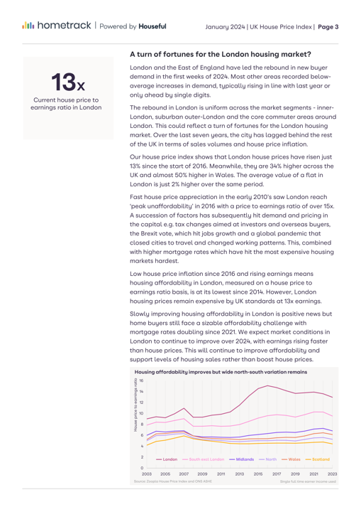

In [20]:
image = Image.open("/home/ubuntu/pdfs/image.png")
scale_image(image, 512)

In [ ]:
model_name = "vidore/colpali-v1.2"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

In [ ]:
# Preprocess inputs
batch_images = processor.process_images([image]).to(device)
batch_queries = processor.process_queries(["london house price"]).to(device)

# Forward passes
with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    #query_embeddings = model.forward(**batch_queries)

In [47]:
len(page_embeddings[0][0])

128

In [42]:
len(query_embeddings[0][0])

128

In [81]:
query_embeddings = token_vectors

In [82]:
query_embeddings.size()

torch.Size([1, 17, 128])

In [63]:
from colpali_engine.models import ColPali, ColPaliProcessor

In [64]:
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(model_name))

In [90]:
# Get the number of image patches
n_patches = processor.get_n_patches(image_size=image.size, patch_size=model.patch_size)

# print(f"Number of image patches: {n_patches}")

# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(batch_images)



AttributeError: 'PaliGemmaProcessor' object has no attribute 'get_n_patches'

In [84]:
image_mask

tensor([[ True,  True,  True,  ..., False, False, False]])

In [75]:
query_embeddings.size()

AttributeError: 'list' object has no attribute 'size'

In [87]:
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=page_embeddings,
    query_embeddings=query_embeddings,
    n_patches=torch.Tensor(10,10),
   image_mask=image_mask,
)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

print(f"Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(similarity_maps.shape)}")

ValueError: The number of patches (7.006492321624085e-45 x 0.0 = 0.0) does not match the number of non-padded image tokens (1024).